Импортируйте необходимые библиотеки:

In [6]:
import pandas as pd
import numpy as np
from openai import OpenAI
from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_gigachat.embeddings.gigachat import GigaChatEmbeddings
from langchain_gigachat.chat_models import GigaChat
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
import ast

Загрузите датасет:

In [7]:
# Функция загрузки датасета
def load_embeddings_to_dataframe(filepath):
    """
    Загружает данные эмбеддингов из CSV файла в pandas DataFrame

    Args:
        filepath (str): Путь к файлу с данными

    Returns:
        pd.DataFrame: DataFrame с загруженными данными
    """
    try:
        df = pd.read_csv(filepath)
        print(f"Загружено {len(df)} записей из файла {filepath}")
        print(f"Колонки: {df.columns.tolist()}")
        print(f"\nПервые 3 записи:")
        print(df.head(3))
        return df
    except Exception as e:
        print(f"Произошла ошибка при загрузке данных: {e}")
        return None

# Загрузка данных
df = load_embeddings_to_dataframe("arxiv_embeddings202505211515.csv")

Загружено 50000 записей из файла arxiv_embeddings202505211515.csv
Колонки: ['article_id', 'submitter', 'authors', 'title', 'comments', 'journal_ref', 'doi', 'report_no', 'categories', 'main_category', 'other_categories', 'license', 'abstract', 'versions', 'authors_parsed', 'year', 'embedding_bge_m3']

Первые 3 записи:
     article_id submitter                                            authors  \
0  2410.08001v2       NaN  {"Qingwen Bu","Hongyang Li","Li Chen","Jisong ...   
1  2410.11878v1       NaN                     {"Xingyi Yang","Xinchao Wang"}   
2  2410.07991v3       NaN  {"Tommaso Giorgi","Lorenzo Cima","Tiziano Fagn...   

                                               title comments journal_ref  \
0  Towards Synergistic, Generalized, and Efficien...      NaN         NaN   
1                               Neural Metamorphosis      NaN         NaN   
2  Human and LLM Biases in Hate Speech Annotation...      NaN         NaN   

   doi report_no           categories main_categor

Изучите структуру данных:

In [8]:
# Просмотр информации о датасете
print(f"Размер датасета: {df.shape}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПроверка пропущенных значений:\n{df.isnull().sum()}")

Размер датасета: (50000, 17)

Типы данных:
article_id          object
submitter           object
authors             object
title               object
comments            object
journal_ref         object
doi                 object
report_no           object
categories          object
main_category       object
other_categories    object
license             object
abstract            object
versions            object
authors_parsed      object
year                 int64
embedding_bge_m3    object
dtype: object

Проверка пропущенных значений:
article_id              0
submitter            9197
authors                 0
title                   0
comments            23907
journal_ref         43700
doi                 43125
report_no           47991
categories              0
main_category           0
other_categories     6907
license              9363
abstract                0
versions             9197
authors_parsed       9197
year                    0
embedding_bge_m3        0
dtype: int

Задание для самостоятельной работы:
- Выведите статистику по категориям статей


📊 Статистика по категориям (топ-15):
main_category
cs.LG      260
cs.CL      220
cs.CV      128
cs.AI      109
cs.RO       39
cs.CR       32
cs.CY       23
cs.HC       22
cs.IR       22
cs.SD       17
cs.SE       17
eess.IV     11
eess.SP     11
cs.NE        8
eess.AS      6
Name: count, dtype: int64


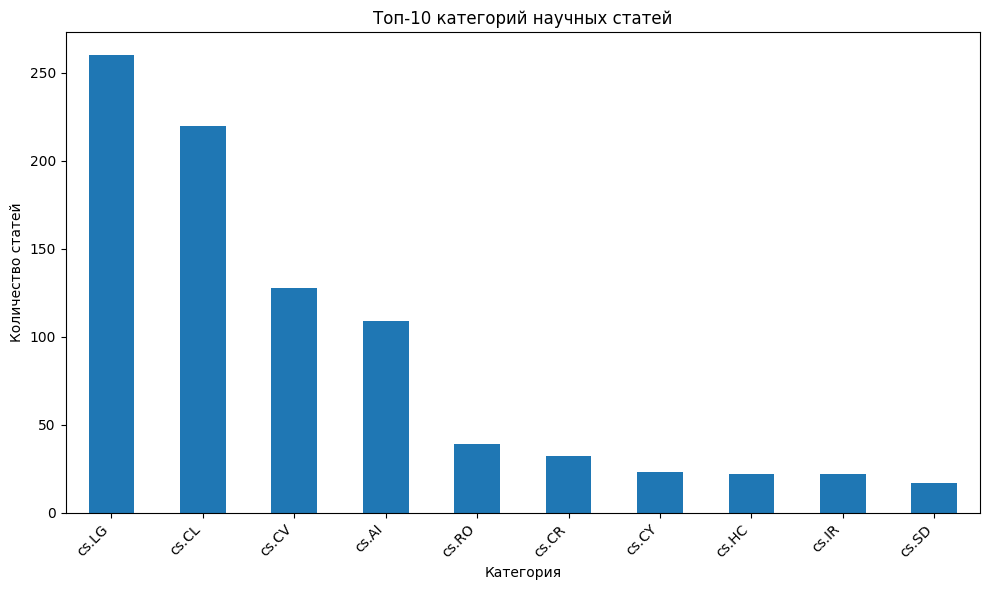

In [9]:
# Задание для самостоятельной работы: Вывести статистику по категориям статей
if 'main_category' in df.head(1000).columns:
    category_counts = df['main_category'].head(1000).value_counts()
    print("\n📊 Статистика по категориям (топ-15):")
    print(category_counts.head(15))

    # Опционально: визуализация (если разрешено использовать matplotlib)
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        category_counts.head(10).plot(kind='bar')
        plt.title("Топ-10 категорий научных статей")
        plt.xlabel("Категория")
        plt.ylabel("Количество статей")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("Ошибка!!!")

In [10]:

# Выбор подмножества — первые 1000 записей
df_sample = df.head(1000).copy()
print(f"\n✅ Выбрано {len(df_sample)} статей для дальнейшей работы")


✅ Выбрано 1000 статей для дальнейшей работы


In [11]:
def prepare_documents(df, limit=1000):
    """
    Преобразует DataFrame в список документов LangChain

    Args:
        df: DataFrame с данными статей
        limit: Количество документов для обработки

    Returns:
        List[Document]: Список документов
    """
    documents = []
    df_subset = df.head(limit)
    for _, row in df_subset.iterrows():
        page_content = ""
        if pd.notna(row.get('title')):
            page_content += f"Название: {row['title']}\n"
        if pd.notna(row.get('abstract')):
            page_content += f"Аннотация: {row['abstract']}\n"
        if pd.notna(row.get('authors')):
            page_content += f"Авторы: {row['authors']}\n"

        metadata = {
            'article_id': row.get('article_id', ''),
            'main_category': row.get('main_category', ''),
            'year': row.get('year', ''),
            'license': row.get('license', '')
        }
        documents.append(Document(page_content=page_content.strip(), metadata=metadata))
    print(f"Подготовлено {len(documents)} документов")
    return documents

documents = prepare_documents(df_sample, limit=1000)
print("\nПример документа:")
print(f"Содержимое:\n{documents[0].page_content[:200]}...")
print(f"Метаданные: {documents[0].metadata}")

Подготовлено 1000 документов

Пример документа:
Содержимое:
Название: Towards Synergistic, Generalized, and Efficient Dual-System for Robotic Manipulation
Аннотация: The increasing demand for versatile robotic systems to operate in diverse and
dynamic environm...
Метаданные: {'article_id': '2410.08001v2', 'main_category': 'cs.RO', 'year': 2024, 'license': nan}


In [12]:
client = OpenAI(
    api_key="ZmJhMjUwZTItMDg0ZC00N2E3LWIyNDktYjA4MTQyZGFmMGE4.97f6d089a16317c3aa93b365eda739a8",
    base_url="https://foundation-models.api.cloud.ru/v1"
)

def get_embedding(text: str, model="BAAI/bge-m3") -> list:
    """Получает эмбеддинг текста"""
    response = client.embeddings.create(input=[text], model=model)
    return response.data[0].embedding

# Тест
test_emb = get_embedding("Тест")
print(f"Размерность эмбеддинга: {len(test_emb)}")  # Должно быть 1024

Размерность эмбеддинга: 1024


In [13]:
from langchain_core.embeddings import Embeddings
from typing import List


class CustomEmbeddings(Embeddings):
    """Кастомный класс эмбеддингов для работы с API"""

    def __init__(self, client, model="BAAI/bge-m3"):
        self.client = client
        self.model = model

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Получение эмбеддингов для списка документов"""
        embeddings = []
        for text in texts:
            emb = self.client.embeddings.create(input=[text], model=self.model).data[0].embedding
            embeddings.append(emb)
        return embeddings

    def embed_query(self, text: str) -> List[float]:
        """Получение эмбеддинга для запроса"""
        return self.client.embeddings.create(input=[text], model=self.model).data[0].embedding

embeddings = CustomEmbeddings(client)

In [14]:
# Создание векторного хранилища ChromaDB
print("Создание векторного хранилища...")
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    collection_name="arxiv_papers",
    persist_directory="./chroma_db"  # Директория для сохранения
)
print("Векторное хранилище успешно создано!")

# Проверка работы хранилища
test_query = "машинное обучение и нейронные сети"
results = vectorstore.similarity_search(test_query, k=3)
print(f"\nРезультаты поиска по запросу '{test_query}':")
for i, doc in enumerate(results, 1):
    print(f"\n{i}. {doc.page_content[:200]}...")
    print(f"   Метаданные: {doc.metadata}")

Создание векторного хранилища...
Векторное хранилище успешно создано!

Результаты поиска по запросу 'машинное обучение и нейронные сети':

1. Название: Neural Reasoning Networks: Efficient Interpretable Neural Networks With Automatic Textual Explanations
Аннотация: Recent advances in machine learning have led to a surge in adoption of neura...
   Метаданные: {'article_id': '2410.07966v1', 'main_category': 'cs.LG', 'year': 2024}

2. Название: Neural Reasoning Networks: Efficient Interpretable Neural Networks With Automatic Textual Explanations
Аннотация: Recent advances in machine learning have led to a surge in adoption of neura...
   Метаданные: {'year': 2024, 'article_id': '2410.07966v1', 'main_category': 'cs.LG'}

3. Название: A Scientific Machine Learning Approach for Predicting and Forecasting Battery Degradation in Electric Vehicles
Аннотация: Carbon emissions are rising at an alarming rate, posing a significan...
   Метаданные: {'year': 2024, 'main_category': 'cs.LG', 'article_i

In [15]:
print(" Эксперимент с разными значениями k:")

k_values = [1, 3, 5, 10]

for k in k_values:
        results = vectorstore.similarity_search( "машинное обучение и нейронные сети", k=k)

        for i, doc in enumerate(results, 1):
           print(f"\n{i}. {doc.page_content[:200]}...")
        print(f"  k={k} → найдено документов: {len(results)}")

 Эксперимент с разными значениями k:

1. Название: Neural Reasoning Networks: Efficient Interpretable Neural Networks With Automatic Textual Explanations
Аннотация: Recent advances in machine learning have led to a surge in adoption of neura...
  k=1 → найдено документов: 1

1. Название: Neural Reasoning Networks: Efficient Interpretable Neural Networks With Automatic Textual Explanations
Аннотация: Recent advances in machine learning have led to a surge in adoption of neura...

2. Название: Neural Reasoning Networks: Efficient Interpretable Neural Networks With Automatic Textual Explanations
Аннотация: Recent advances in machine learning have led to a surge in adoption of neura...

3. Название: A Scientific Machine Learning Approach for Predicting and Forecasting Battery Degradation in Electric Vehicles
Аннотация: Carbon emissions are rising at an alarming rate, posing a significan...
  k=3 → найдено документов: 3

1. Название: Neural Reasoning Networks: Efficient Interpretable Neural

In [16]:
print("\n Тематические поисковые запросы:")

thematic_queries = [
    "машинное обучение",
    "нейронные сети",
    "обработка естественного языка",
    "компьютерное зрение",
    "квантовая физика",
    "геномика",
    "робототехника",
    "криптография"
]

for q in thematic_queries:
    results = vectorstore.similarity_search(q, k=2)
    print(f"\nЗапрос: '{q}'")
    for i, doc in enumerate(results, 1):
        title = doc.page_content.split('\n')[0] if doc.page_content else "Без названия"
        cat = doc.metadata.get('main_category', 'N/A')
        print(f"  {i}. {title} | Категория: {cat}")


 Тематические поисковые запросы:

Запрос: 'машинное обучение'
  1. Название: CodeUnlearn: Amortized Zero-Shot Machine Unlearning in Language Models Using Discrete Concept | Категория: cs.CL
  2. Название: CodeUnlearn: Amortized Zero-Shot Machine Unlearning in Language Models Using Discrete Concept | Категория: cs.CL

Запрос: 'нейронные сети'
  1. Название: Neural Reasoning Networks: Efficient Interpretable Neural Networks With Automatic Textual Explanations | Категория: cs.LG
  2. Название: Neural Reasoning Networks: Efficient Interpretable Neural Networks With Automatic Textual Explanations | Категория: cs.LG

Запрос: 'обработка естественного языка'
  1. Название: Herald: A Natural Language Annotated Lean 4 Dataset | Категория: cs.CL
  2. Название: Herald: A Natural Language Annotated Lean 4 Dataset | Категория: cs.CL

Запрос: 'компьютерное зрение'
  1. Название: Do better language models have crisper vision? | Категория: cs.CL
  2. Название: Do better language models have crisper vi

In [17]:
query = "машинное обучение и нейронные сети"
print(f"\n📊 Поиск с оценками схожести для запроса: '{query}'")

results_with_scores = vectorstore.similarity_search_with_relevance_scores(query, k=5)

for i, (doc, score) in enumerate(results_with_scores, 1):
    title_line = doc.page_content.split('\n')[0] if doc.page_content else "Без названия"
    print(f"{i}. Схожесть: {score:.4f} → {title_line[:80]}...")
    print(f"   Категория: {doc.metadata.get('main_category', 'N/A')}")


📊 Поиск с оценками схожести для запроса: 'машинное обучение и нейронные сети'
1. Схожесть: 0.3484 → Название: Neural Reasoning Networks: Efficient Interpretable Neural Networks Wit...
   Категория: cs.LG
2. Схожесть: 0.3484 → Название: Neural Reasoning Networks: Efficient Interpretable Neural Networks Wit...
   Категория: cs.LG
3. Схожесть: 0.3474 → Название: A Scientific Machine Learning Approach for Predicting and Forecasting ...
   Категория: cs.LG
4. Схожесть: 0.3474 → Название: A Scientific Machine Learning Approach for Predicting and Forecasting ...
   Категория: cs.LG
5. Схожесть: 0.3454 → Название: NegMerge: Consensual Weight Negation for Strong Machine Unlearning...
   Категория: cs.LG


In [18]:
# Тематические запросы
queries = [
    "машинное обучение",
    "квантовые вычисления",
    "биоинформатика",
    "нейросети для обработки изображений",
    "генеративные модели"
]

# Разные значения k
k_values = [1, 3, 5, 10]

print("🔍 Тестирование similarity_search_with_score() с разными k и запросами\n")
print("=" * 100)

for query in queries:
    print(f"\n🔎 Запрос: '{query}'")
    print("-" * 60)

    for k in k_values:
        # Используем метод с оценками схожести
        results_with_scores = vectorstore.similarity_search_with_score(query, k=k)

        print(f"\n  k = {k} → Найдено: {len(results_with_scores)} документов")

        for i, (doc, score) in enumerate(results_with_scores, 1):
            # Chroma возвращает "расстояние", но при использовании косинусного сходства
            # через BGE-M3 (через API) — это **сходство**, где 1 = полное совпадение.
            # Однако Chroma по умолчанию хранит как **расстояние**, поэтому сходство = 1 - расстояние
            # Но! При использовании `cosine` в Chroma с внешними эмбеддингами,
            # `similarity_search_with_score` возвращает **косинусную близость напрямую** (в [0, 1]).
            # Проверим: если score > 1 — это расстояние; если ≤1 — сходство.
            similarity = score

            title = ""
            if "Название:" in doc.page_content:
                title_line = doc.page_content.split("Название:")[1].split("\n")[0].strip()
                title = title_line[:60] + ("..." if len(title_line) > 60 else "")
            else:
                title = doc.page_content[:60] + ("..." if len(doc.page_content) > 60 else "")

            category = doc.metadata.get('main_category', 'N/A')
            print(f"    {i}. [{similarity:.4f}] {title} | Категория: {category}")
    print("\n" + "=" * 100)

🔍 Тестирование similarity_search_with_score() с разными k и запросами


🔎 Запрос: 'машинное обучение'
------------------------------------------------------------

  k = 1 → Найдено: 1 документов
    1. [0.8116] CodeUnlearn: Amortized Zero-Shot Machine Unlearning in Langu... | Категория: cs.CL

  k = 3 → Найдено: 3 документов
    1. [0.8116] CodeUnlearn: Amortized Zero-Shot Machine Unlearning in Langu... | Категория: cs.CL
    2. [0.8116] CodeUnlearn: Amortized Zero-Shot Machine Unlearning in Langu... | Категория: cs.CL
    3. [0.8451] A Scientific Machine Learning Approach for Predicting and Fo... | Категория: cs.LG

  k = 5 → Найдено: 5 документов
    1. [0.8116] CodeUnlearn: Amortized Zero-Shot Machine Unlearning in Langu... | Категория: cs.CL
    2. [0.8116] CodeUnlearn: Amortized Zero-Shot Machine Unlearning in Langu... | Категория: cs.CL
    3. [0.8451] A Scientific Machine Learning Approach for Predicting and Fo... | Категория: cs.LG
    4. [0.8451] A Scientific Machine Learning

In [63]:
# Создание ретривера с поиском по схожести
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 10}  # Возвращать топ-5 документов
)

# Тестирование ретривера
retrieved_docs = retriever.invoke("глубокое обучение для обработки изображений")

print(f"Найдено документов: {len(retrieved_docs)}")

for d in docs:
    print("-", d.metadata.get('main_category'))

for i, doc in enumerate(retrieved_docs, 1):
    print(f"\nДокумент {i}:")
    print(doc.page_content[:150] + "...")

Найдено документов: 10
- cs.LG
- cs.LG
- cs.CL

Документ 1:
Название: Deep Learning Applications in Medical Image Analysis: Advancements, Challenges, and Future Directions
Аннотация: Medical image analysis has ...

Документ 2:
Название: Deep Learning Applications in Medical Image Analysis: Advancements, Challenges, and Future Directions
Аннотация: Medical image analysis has ...

Документ 3:
Название: Core Tokensets for Data-efficient Sequential Training of Transformers
Аннотация: Deep networks are frequently tuned to novel tasks and conti...

Документ 4:
Название: Core Tokensets for Data-efficient Sequential Training of Transformers
Аннотация: Deep networks are frequently tuned to novel tasks and conti...

Документ 5:
Название: Reconstruction of Particle Flow Energy Distribution Using Deep Learning Algorithms
Аннотация: In high-energy particle physics, extracting in...

Документ 6:
Название: Reconstruction of Particle Flow Energy Distribution Using Deep Learning Algorithms
Аннотация: I

In [21]:
# MMR балансирует между релевантностью и разнообразием результатов
retriever_mmr = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 5,
        "fetch_k": 20,  # Количество документов для первичной выборки
        "lambda_mult": 0.5  # Баланс между релевантностью (1.0) и разнообразием (0.0)
    }
)

# Сравнение результатов
query = "генеративный искусственный интеллект"
docs_similarity = retriever.invoke(query)
docs_mmr = retriever_mmr.invoke(query)

print("Сравнение результатов поиска:")
print("\n=== Similarity Search ===")
for i, doc in enumerate(docs_similarity[:3], 1):
    print(f"{i}. {doc.page_content[:100]}...")

print("\n=== MMR Search ===")
for i, doc in enumerate(docs_mmr[:3], 1):
    print(f"{i}. {doc.page_content[:100]}...")

Сравнение результатов поиска:

=== Similarity Search ===
1. Название: Generative AI, Pragmatics, and Authenticity in Second Language Learning
Аннотация: There a...
2. Название: Generative AI, Pragmatics, and Authenticity in Second Language Learning
Аннотация: There a...
3. Название: Masked Generative Priors Improve World Models Sequence Modelling Capabilities
Аннотация: D...

=== MMR Search ===
1. Название: Generative AI, Pragmatics, and Authenticity in Second Language Learning
Аннотация: There a...
2. Название: Gamified crowd-sourcing of high-quality data for visual fine-tuning
Аннотация: This paper ...
3. Название: Block Induced Signature Generative Adversarial Network (BISGAN): Signature Spoofing Using ...


In [22]:
retriever_threshold = vectorstore.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "score_threshold": 0.7,  # Минимальная оценка схожести
        "k": 10
    }
)

In [23]:
# Тестовый запрос
query = "трансформеры в обработке естественного языка"

# Значения lambda_mult для тестирования
lambda_values = [0.0, 0.5, 1.0]

print(" Эксперимент с lambda_mult в MMR")
print("=" * 80)

for lam in lambda_values:
    retriever_mmr_test = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={
            "k": 3,
            "fetch_k": 15,
            "lambda_mult": lam
        }
    )
    docs = retriever_mmr_test.invoke(query)

    print(f"\nlambda_mult = {lam}")
    print("-" * 40)
    for i, doc in enumerate(docs, 1):
        title = ""
        if "Название:" in doc.page_content:
            title = doc.page_content.split("Название:")[1].split("\n")[0].strip()
        else:
            title = doc.page_content[:80]
        category = doc.metadata.get('main_category', 'N/A')
        print(f"  {i}. {title[:70]}... | {category}")

 Эксперимент с lambda_mult в MMR

lambda_mult = 0.0
----------------------------------------
  1. Extracting Finite State Machines from Transformers... | cs.LG
  2. Herald: A Natural Language Annotated Lean 4 Dataset... | cs.CL
  3. Accelerating Error Correction Code Transformers... | cs.LG

lambda_mult = 0.5
----------------------------------------
  1. Extracting Finite State Machines from Transformers... | cs.LG
  2. Herald: A Natural Language Annotated Lean 4 Dataset... | cs.CL
  3. Accelerating Error Correction Code Transformers... | cs.LG

lambda_mult = 1.0
----------------------------------------
  1. Extracting Finite State Machines from Transformers... | cs.LG
  2. Extracting Finite State Machines from Transformers... | cs.LG
  3. Joint Fine-tuning and Conversion of Pretrained Speech and Language Mod... | cs.CL


In [24]:
import time

def benchmark_retrievers(query: str, k: int = 5, repeat: int = 3):
    """
    Сравнивает время работы трёх типов ретриверов:
    - similarity
    - mmr (с lambda_mult=0.5)
    - similarity_score_threshold (эмуляция через фильтрацию)
    """
    print(f"\n⏱️  Тест производительности ретриверов | Запрос: '{query}' | Повторов: {repeat}")
    print("=" * 90)

    results = {}

    # 1. Similarity
    retriever_sim = vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={"k": k}
    )
    times_sim = []
    for _ in range(repeat):
        start = time.time()
        retriever_sim.invoke(query)
        times_sim.append(time.time() - start)
    results['similarity'] = np.mean(times_sim)

    # 2. MMR
    retriever_mmr = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={"k": k, "fetch_k": k * 4, "lambda_mult": 0.5}
    )
    times_mmr = []
    for _ in range(repeat):
        start = time.time()
        retriever_mmr.invoke(query)
        times_mmr.append(time.time() - start)
    results['mmr'] = np.mean(times_mmr)

    # 3. Threshold (эмуляция, так как Chroma не поддерживает напрямую)
    def retriever_threshold_manual(query, k=10, threshold=0.7):
        results = vectorstore.similarity_search_with_score(query, k=k)
        return [doc for doc, score in results if score >= threshold]

    times_thr = []
    for _ in range(repeat):
        start = time.time()
        retriever_threshold_manual(query, k=k*2, threshold=0.7)
        times_thr.append(time.time() - start)
    results['threshold_emulated'] = np.mean(times_thr)

    # Вывод
    for name, avg_time in results.items():
        print(f"{name:>20}: {avg_time:.4f} сек (в среднем за {repeat} запусков)")

    return results

# Запуск бенчмарка
benchmark_results = benchmark_retrievers(
    query="машинное обучение и градиентный спуск",
    k=5,
    repeat=3
)


⏱️  Тест производительности ретриверов | Запрос: 'машинное обучение и градиентный спуск' | Повторов: 3
          similarity: 0.1598 сек (в среднем за 3 запусков)
                 mmr: 0.2956 сек (в среднем за 3 запусков)
  threshold_emulated: 0.1603 сек (в среднем за 3 запусков)


Шаг 4.1: Настройте языковую модель GigaChat:

In [42]:
from langchain_community.chat_models.gigachat import GigaChat

llm = GigaChat(
    credentials="YTViNDBiOGUtNzE2MS00MmQ1LWE5NmYtZjEzOWYwZjQzZjAxOmU3MTQzOGYxLTc4ZWMtNDFkZS05MzkzLWIxNDQ4NThmMThkOQ==",
    scope="GIGACHAT_API_B2B",
    model="GigaChat-2-Max",
    verify_ssl_certs=False,
)

# Тест языковой модели
test_response = llm.invoke("Привет! Ответь кратко: что такое машинное обучение?")
print(f"Ответ модели: {test_response.content}")


Ответ модели: Машинное обучение — это область искусственного интеллекта, где компьютеры учатся выявлять закономерности и принимать решения на основе анализа данных без явного программирования каждого шага.


Шаг 4.2: Создайте промпт-шаблон:

In [66]:
# Шаблон промпта для RAG
prompt_template = """Ты -- научный ассистент, специализирующийся на анализе научных статей.
Твоя задача -- отвечать на вопросы пользователя, основываясь ТОЛЬКО на предоставленном контексте из научных статей ArXiv.

Правила:
1. Используй только информацию из контекста ниже
2. Если в контексте нет информации для ответа, честно скажи об этом
3. Указывай, из каких статей взята информация (если есть метаданные)
4. Отвечай на русском языке, четко и структурированно
5. Если вопрос касается технических деталей, будь точным

Контекст из научных статей:
{context}

Вопрос пользователя: {question}

Ответ:"""

prompt = ChatPromptTemplate.from_template(prompt_template)

Шаг 4.3: Создайте функцию форматирования контекста:

In [57]:
def format_docs(docs):
    """
    Форматирует список документов в единую строку контекста

    Args:
        docs: Список документов Document

    Returns:
        str: Форматированный контекст
    """
    context_parts = []
    for i, doc in enumerate(docs, 1):
        context_parts.append(f"[Документ {i}]")
        context_parts.append(doc.page_content)
        if doc.metadata:
            context_parts.append(f"Метаданные: {doc.metadata}")
        context_parts.append("")  # Пустая строка для разделения
    return "\n".join(context_parts)

# Тест форматирования
test_docs = retriever.invoke("нейронные сети")
formatted_context = format_docs(test_docs[:2])
print("Пример форматированного контекста:")
print(formatted_context[:500] + "...")

Пример форматированного контекста:
[Документ 1]
Название: Neural Reasoning Networks: Efficient Interpretable Neural Networks With Automatic Textual Explanations
Аннотация: Recent advances in machine learning have led to a surge in adoption of neural
networks for various tasks, but lack of interpretability remains an issue for
many others in which an understanding of the features influencing the
prediction is necessary to ensure fairness, safety, and legal compliance. In
this paper we consider one class of such tasks, tabular data...


Шаг 4.4: Соберите RAG-цепочку:

In [58]:
from langchain_core.runnables import RunnablePassthrough

# Создание RAG-цепочки
rag_chain = (
    {
        "context": retriever | format_docs,  # Извлекаем и форматируем документы
        "question": RunnablePassthrough()     # Передаем вопрос как есть
    }
    | prompt      # Формируем промпт
    | llm         # Отправляем в языковую модель
)

In [59]:
# Тестирование RAG-системы
questions = [
    "Какие методы машинного обучения используются для обработки изображений?",
    "Расскажи о применении трансформеров в обработке естественного языка",
    "Какие существуют подходы к обучению нейронных сетей?"
]

print("=== Тестирование RAG-системы ===\n")
for i, question in enumerate(questions, 1):
    print(f"Вопрос {i}: {question}")
    print("-" * 80)

    try:
        response = rag_chain.invoke(question)
        print(f"Ответ: {response.content}\n")
    except Exception as e:
        print(f"Ошибка: {e}\n")



=== Тестирование RAG-системы ===

Вопрос 1: Какие методы машинного обучения используются для обработки изображений?
--------------------------------------------------------------------------------
Ответ: На основе представленных документов, в обработке изображений применяются следующие методы машинного обучения:

### Медицинская визуализация (Документы 1 и 2):
- **Глубокое обучение**  
- **Свёрточные нейронные сети (Convolutional Neural Networks — CNN)**  
Эти модели широко используются для анализа медицинских снимков, включая МРТ, КТ и рентгенографию, позволяя автоматизировать процессы диагностики заболеваний и сегментации тканей.

### Редактирование изображений (Документы 3 и 4): 
- Метод **PostEdit**, использующий диффузионное моделирование и схему постериорного распределения (posterior sampling). Этот метод эффективен для редактирования изображений с сохранением фона и минимальными вычислительными затратами (~1.5 секунды и ~18 ГБ видеопамяти).

### Цветизация изображений (Документ 

Шаг 4.5: Создайте интерактивную систему вопросов-ответов:

С какими сложностями сталкиваются современные крупные языковые модели при обработке сложных концепций временного ряда?

In [68]:
def interactive_rag_qa():
    """Интерактивная система вопросов-ответов"""
    print("=== Интерактивная RAG-система для научных статей ArXiv ===")
    print("Введите 'выход' для завершения\n")

    while True:
        question = input("Ваш вопрос: ").strip()

        if question.lower() in ['выход', 'exit', 'quit']:
            print("До свидания!")
            break

        if not question:
            continue

        try:
            # Получаем релевантные документы
            docs = retriever.invoke(question)
            print(f"\n📚 Найдено релевантных документов: {len(docs)}")

            # Генерируем ответ
            response = rag_chain.invoke(question)
            print(f"\n🤖 Ответ:\n{response.content}\n")

            # Показываем источники
            show_sources = input("Показать источники? (да/нет): ").strip().lower()
            if show_sources in ['да', 'yes', 'y', 'д', '+']:
                print("\n📖 Источники:")
                for i, doc in enumerate(docs, 1):
                    print(f"\n{i}. {doc.page_content}...")
                    print(f"   Метаданные: {doc.metadata}")

            print("\n" + "="*80 + "\n")

        except Exception as e:
            print(f"❌ Ошибка: {e}\n")

# Запуск интерактивной системы (раскомментируйте для использования)
interactive_rag_qa()

=== Интерактивная RAG-система для научных статей ArXiv ===
Введите 'выход' для завершения


📚 Найдено релевантных документов: 10

🤖 Ответ:
На основе представленного контекста, можно выделить следующие сложности крупных языковых моделей (LLMs) при обработке временных рядов:

### Из документа [1]:
- **Проблема временной последовательности**: Даже самые мощные LLMs испытывают трудности с задачей построения временной графической структуры событий («temporal graph generation»), показывая значительные проблемы даже на мощных моделях типа GPT-3.5/4.
  
- **Разрыв производительности между большими и малыми моделями**: Меньшие модели значительно отстают от больших LLMs примерно на 50% в задаче временного анализа, подчеркивая сложность обработки этой задачи малыми ресурсами.

---

### Из документа [3]:
- **Игнорирование временного аспекта**: Большинство существующих видеоязыковых моделей игнорируют временную составляющую видео-данных, затрудняя понимание задач, связанных с осознанием течения вре

KeyboardInterrupt: Interrupted by user